In [1]:
# import all libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
torch.__version__

'1.9.1'

In [4]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# these are commonly used data augmentations
# random cropping and random horizontal flip
# lastly, we normalize each channel into zero mean and unit standard deviation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.4), ratio=(0.3, 3.3), value=(125,122,114), inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# we can use a larger batch size during test, because we do not save 
# intermediate variables for gradient computation, which leaves more memory
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Training
def train(epoch, net, criterion, trainloader,scheduler):
    device = 'cuda'
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
       
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1) % 50 == 0:
            print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

In [7]:
def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = net(inputs)

            loss= criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total



In [8]:
def save_checkpoint(net, acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')





In [9]:
# defining resnet models
from dropblock import DropBlock2D, LinearScheduler

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, drop_prob=0.7, block_size=7):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # This is the "stem"
        # For CIFAR (32x32 images), it does not perform downsampling
        # It should downsample for ImageNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropblock = LinearScheduler(
            DropBlock2D(drop_prob=drop_prob, block_size=block_size),
            start_value=0.,
            stop_value=drop_prob,
            nr_steps=5e3
        )
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        self.dropblock.step() 
        out = F.relu(self.bn1(self.conv1(x)))
        #out = self.layer1(out)
        #out = self.layer2(out)
        out = self.dropblock(self.layer1(out))
        out = self.dropblock(self.layer2(out))
        
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


In [10]:
# main body
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 5e-4
}

train_loss_list = []
train_acc_list  = []
test_loss_list  = []
test_acc_list  = []


net = ResNet18().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
#print(scheduler)
for epoch in range(0, 200):
    # normal - train, jaco- jaco_train, mma - mma_train
    train_loss, train_acc = train(epoch, net, criterion, trainloader,scheduler)
    test_loss, test_acc = test(epoch, net, criterion, testloader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
      ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    


Epoch: 0
iteration :  50, loss : 1.9129, accuracy : 28.64
iteration : 100, loss : 1.7705, accuracy : 34.20
iteration : 150, loss : 1.6823, accuracy : 37.67
iteration : 200, loss : 1.6112, accuracy : 40.42
iteration : 250, loss : 1.5523, accuracy : 42.79
iteration : 300, loss : 1.5009, accuracy : 44.76
iteration : 350, loss : 1.4567, accuracy : 46.59
Epoch :   0, training loss : 1.4263, training accuracy : 47.82, test loss : 1.2662, test accuracy : 57.85

Epoch: 1
iteration :  50, loss : 1.1293, accuracy : 59.77
iteration : 100, loss : 1.1067, accuracy : 60.27
iteration : 150, loss : 1.0795, accuracy : 61.43
iteration : 200, loss : 1.0601, accuracy : 62.12
iteration : 250, loss : 1.0401, accuracy : 62.79
iteration : 300, loss : 1.0272, accuracy : 63.29
iteration : 350, loss : 1.0117, accuracy : 63.92
Epoch :   1, training loss : 1.0001, training accuracy : 64.43, test loss : 0.9532, test accuracy : 66.85

Epoch: 2
iteration :  50, loss : 0.9092, accuracy : 67.62
iteration : 100, loss :

iteration :  50, loss : 0.5705, accuracy : 80.38
iteration : 100, loss : 0.5634, accuracy : 80.33
iteration : 150, loss : 0.5600, accuracy : 80.40
iteration : 200, loss : 0.5626, accuracy : 80.31
iteration : 250, loss : 0.5605, accuracy : 80.34
iteration : 300, loss : 0.5599, accuracy : 80.34
iteration : 350, loss : 0.5605, accuracy : 80.30
Epoch :  18, training loss : 0.5622, training accuracy : 80.31, test loss : 0.3869, test accuracy : 86.72

Epoch: 19
iteration :  50, loss : 0.5470, accuracy : 81.28
iteration : 100, loss : 0.5570, accuracy : 80.50
iteration : 150, loss : 0.5559, accuracy : 80.47
iteration : 200, loss : 0.5559, accuracy : 80.49
iteration : 250, loss : 0.5533, accuracy : 80.67
iteration : 300, loss : 0.5512, accuracy : 80.67
iteration : 350, loss : 0.5507, accuracy : 80.63
Epoch :  19, training loss : 0.5501, training accuracy : 80.61, test loss : 0.4437, test accuracy : 85.22

Epoch: 20
iteration :  50, loss : 0.5459, accuracy : 81.02
iteration : 100, loss : 0.5397,

iteration :  50, loss : 0.3906, accuracy : 85.95
iteration : 100, loss : 0.4031, accuracy : 85.75
iteration : 150, loss : 0.4069, accuracy : 85.69
iteration : 200, loss : 0.4149, accuracy : 85.44
iteration : 250, loss : 0.4177, accuracy : 85.33
iteration : 300, loss : 0.4164, accuracy : 85.41
iteration : 350, loss : 0.4160, accuracy : 85.41
Epoch :  36, training loss : 0.4162, training accuracy : 85.40, test loss : 0.3955, test accuracy : 86.98

Epoch: 37
iteration :  50, loss : 0.4030, accuracy : 85.83
iteration : 100, loss : 0.4094, accuracy : 85.80
iteration : 150, loss : 0.4124, accuracy : 85.75
iteration : 200, loss : 0.4129, accuracy : 85.64
iteration : 250, loss : 0.4116, accuracy : 85.79
iteration : 300, loss : 0.4138, accuracy : 85.66
iteration : 350, loss : 0.4126, accuracy : 85.73
Epoch :  37, training loss : 0.4124, training accuracy : 85.70, test loss : 0.3516, test accuracy : 88.55

Epoch: 38
iteration :  50, loss : 0.4012, accuracy : 85.41
iteration : 100, loss : 0.4028,

iteration :  50, loss : 0.3635, accuracy : 87.25
iteration : 100, loss : 0.3470, accuracy : 87.88
iteration : 150, loss : 0.3471, accuracy : 87.89
iteration : 200, loss : 0.3416, accuracy : 88.10
iteration : 250, loss : 0.3452, accuracy : 87.99
iteration : 300, loss : 0.3442, accuracy : 87.99
iteration : 350, loss : 0.3439, accuracy : 87.93
Epoch :  54, training loss : 0.3448, training accuracy : 87.93, test loss : 0.3824, test accuracy : 87.84

Epoch: 55
iteration :  50, loss : 0.3329, accuracy : 88.72
iteration : 100, loss : 0.3322, accuracy : 88.41
iteration : 150, loss : 0.3361, accuracy : 88.26
iteration : 200, loss : 0.3342, accuracy : 88.24
iteration : 250, loss : 0.3338, accuracy : 88.24
iteration : 300, loss : 0.3366, accuracy : 88.09
iteration : 350, loss : 0.3387, accuracy : 88.05
Epoch :  55, training loss : 0.3402, training accuracy : 88.06, test loss : 0.2997, test accuracy : 90.29

Epoch: 56
iteration :  50, loss : 0.3186, accuracy : 88.95
iteration : 100, loss : 0.3386,

iteration :  50, loss : 0.2919, accuracy : 89.83
iteration : 100, loss : 0.2827, accuracy : 90.13
iteration : 150, loss : 0.2862, accuracy : 89.91
iteration : 200, loss : 0.2908, accuracy : 89.83
iteration : 250, loss : 0.2878, accuracy : 89.88
iteration : 300, loss : 0.2894, accuracy : 89.85
iteration : 350, loss : 0.2916, accuracy : 89.80
Epoch :  72, training loss : 0.2920, training accuracy : 89.76, test loss : 0.3740, test accuracy : 88.38

Epoch: 73
iteration :  50, loss : 0.2852, accuracy : 90.06
iteration : 100, loss : 0.2811, accuracy : 90.14
iteration : 150, loss : 0.2832, accuracy : 90.11
iteration : 200, loss : 0.2874, accuracy : 89.85
iteration : 250, loss : 0.2891, accuracy : 89.74
iteration : 300, loss : 0.2867, accuracy : 89.85
iteration : 350, loss : 0.2897, accuracy : 89.79
Epoch :  73, training loss : 0.2899, training accuracy : 89.82, test loss : 0.3308, test accuracy : 89.70

Epoch: 74
iteration :  50, loss : 0.2737, accuracy : 90.36
iteration : 100, loss : 0.2732,

iteration :  50, loss : 0.2408, accuracy : 91.81
iteration : 100, loss : 0.2388, accuracy : 91.90
iteration : 150, loss : 0.2381, accuracy : 91.81
iteration : 200, loss : 0.2433, accuracy : 91.57
iteration : 250, loss : 0.2446, accuracy : 91.50
iteration : 300, loss : 0.2454, accuracy : 91.43
iteration : 350, loss : 0.2443, accuracy : 91.46
Epoch :  90, training loss : 0.2451, training accuracy : 91.40, test loss : 0.3257, test accuracy : 89.95

Epoch: 91
iteration :  50, loss : 0.2315, accuracy : 92.06
iteration : 100, loss : 0.2393, accuracy : 91.78
iteration : 150, loss : 0.2438, accuracy : 91.67
iteration : 200, loss : 0.2397, accuracy : 91.72
iteration : 250, loss : 0.2427, accuracy : 91.58
iteration : 300, loss : 0.2413, accuracy : 91.63
iteration : 350, loss : 0.2416, accuracy : 91.59
Epoch :  91, training loss : 0.2418, training accuracy : 91.57, test loss : 0.2503, test accuracy : 91.75

Epoch: 92
iteration :  50, loss : 0.2250, accuracy : 91.80
iteration : 100, loss : 0.2307,

iteration :  50, loss : 0.1987, accuracy : 92.94
iteration : 100, loss : 0.1924, accuracy : 93.20
iteration : 150, loss : 0.1929, accuracy : 93.25
iteration : 200, loss : 0.1912, accuracy : 93.32
iteration : 250, loss : 0.1901, accuracy : 93.33
iteration : 300, loss : 0.1925, accuracy : 93.22
iteration : 350, loss : 0.1942, accuracy : 93.19
Epoch : 108, training loss : 0.1955, training accuracy : 93.15, test loss : 0.2617, test accuracy : 91.92

Epoch: 109
iteration :  50, loss : 0.1823, accuracy : 93.55
iteration : 100, loss : 0.1878, accuracy : 93.45
iteration : 150, loss : 0.1833, accuracy : 93.58
iteration : 200, loss : 0.1849, accuracy : 93.61
iteration : 250, loss : 0.1844, accuracy : 93.65
iteration : 300, loss : 0.1845, accuracy : 93.67
iteration : 350, loss : 0.1853, accuracy : 93.64
Epoch : 109, training loss : 0.1863, training accuracy : 93.60, test loss : 0.2847, test accuracy : 91.49

Epoch: 110
iteration :  50, loss : 0.1811, accuracy : 93.56
iteration : 100, loss : 0.187

iteration :  50, loss : 0.1455, accuracy : 94.77
iteration : 100, loss : 0.1460, accuracy : 94.66
iteration : 150, loss : 0.1440, accuracy : 94.76
iteration : 200, loss : 0.1433, accuracy : 94.85
iteration : 250, loss : 0.1426, accuracy : 94.94
iteration : 300, loss : 0.1420, accuracy : 94.99
iteration : 350, loss : 0.1433, accuracy : 94.92
Epoch : 126, training loss : 0.1441, training accuracy : 94.92, test loss : 0.2622, test accuracy : 92.41

Epoch: 127
iteration :  50, loss : 0.1335, accuracy : 95.31
iteration : 100, loss : 0.1302, accuracy : 95.53
iteration : 150, loss : 0.1331, accuracy : 95.38
iteration : 200, loss : 0.1351, accuracy : 95.32
iteration : 250, loss : 0.1365, accuracy : 95.25
iteration : 300, loss : 0.1372, accuracy : 95.20
iteration : 350, loss : 0.1393, accuracy : 95.10
Epoch : 127, training loss : 0.1402, training accuracy : 95.10, test loss : 0.2583, test accuracy : 92.54

Epoch: 128
iteration :  50, loss : 0.1277, accuracy : 95.52
iteration : 100, loss : 0.128

iteration :  50, loss : 0.0898, accuracy : 96.89
iteration : 100, loss : 0.0888, accuracy : 96.96
iteration : 150, loss : 0.0883, accuracy : 96.99
iteration : 200, loss : 0.0921, accuracy : 96.86
iteration : 250, loss : 0.0922, accuracy : 96.88
iteration : 300, loss : 0.0924, accuracy : 96.88
iteration : 350, loss : 0.0938, accuracy : 96.82
Epoch : 144, training loss : 0.0938, training accuracy : 96.82, test loss : 0.2502, test accuracy : 92.89

Epoch: 145
iteration :  50, loss : 0.1030, accuracy : 96.36
iteration : 100, loss : 0.0937, accuracy : 96.59
iteration : 150, loss : 0.0936, accuracy : 96.67
iteration : 200, loss : 0.0915, accuracy : 96.82
iteration : 250, loss : 0.0911, accuracy : 96.86
iteration : 300, loss : 0.0915, accuracy : 96.84
iteration : 350, loss : 0.0914, accuracy : 96.88
Epoch : 145, training loss : 0.0914, training accuracy : 96.89, test loss : 0.2438, test accuracy : 93.08

Epoch: 146
iteration :  50, loss : 0.0877, accuracy : 97.16
iteration : 100, loss : 0.086

iteration :  50, loss : 0.0573, accuracy : 98.16
iteration : 100, loss : 0.0583, accuracy : 98.12
iteration : 150, loss : 0.0599, accuracy : 98.03
iteration : 200, loss : 0.0614, accuracy : 98.00
iteration : 250, loss : 0.0608, accuracy : 98.04
iteration : 300, loss : 0.0611, accuracy : 98.02
iteration : 350, loss : 0.0617, accuracy : 97.99
Epoch : 162, training loss : 0.0625, training accuracy : 97.97, test loss : 0.2453, test accuracy : 93.23

Epoch: 163
iteration :  50, loss : 0.0606, accuracy : 98.03
iteration : 100, loss : 0.0590, accuracy : 98.10
iteration : 150, loss : 0.0556, accuracy : 98.17
iteration : 200, loss : 0.0577, accuracy : 98.04
iteration : 250, loss : 0.0591, accuracy : 98.01
iteration : 300, loss : 0.0586, accuracy : 98.02
iteration : 350, loss : 0.0586, accuracy : 98.03
Epoch : 163, training loss : 0.0591, training accuracy : 97.98, test loss : 0.2508, test accuracy : 93.02

Epoch: 164
iteration :  50, loss : 0.0591, accuracy : 98.05
iteration : 100, loss : 0.062

iteration :  50, loss : 0.0449, accuracy : 98.55
iteration : 100, loss : 0.0446, accuracy : 98.57
iteration : 150, loss : 0.0447, accuracy : 98.56
iteration : 200, loss : 0.0447, accuracy : 98.55
iteration : 250, loss : 0.0447, accuracy : 98.57
iteration : 300, loss : 0.0442, accuracy : 98.57
iteration : 350, loss : 0.0444, accuracy : 98.56
Epoch : 180, training loss : 0.0441, training accuracy : 98.57, test loss : 0.2446, test accuracy : 93.39

Epoch: 181
iteration :  50, loss : 0.0457, accuracy : 98.73
iteration : 100, loss : 0.0428, accuracy : 98.77
iteration : 150, loss : 0.0406, accuracy : 98.80
iteration : 200, loss : 0.0421, accuracy : 98.72
iteration : 250, loss : 0.0421, accuracy : 98.68
iteration : 300, loss : 0.0415, accuracy : 98.70
iteration : 350, loss : 0.0412, accuracy : 98.71
Epoch : 181, training loss : 0.0415, training accuracy : 98.72, test loss : 0.2360, test accuracy : 93.65

Epoch: 182
iteration :  50, loss : 0.0423, accuracy : 98.73
iteration : 100, loss : 0.044

iteration :  50, loss : 0.0355, accuracy : 98.84
iteration : 100, loss : 0.0342, accuracy : 98.91
iteration : 150, loss : 0.0356, accuracy : 98.90
iteration : 200, loss : 0.0345, accuracy : 98.93
iteration : 250, loss : 0.0352, accuracy : 98.92
iteration : 300, loss : 0.0370, accuracy : 98.86
iteration : 350, loss : 0.0372, accuracy : 98.86
Epoch : 198, training loss : 0.0367, training accuracy : 98.87, test loss : 0.2302, test accuracy : 93.71

Epoch: 199
iteration :  50, loss : 0.0388, accuracy : 98.77
iteration : 100, loss : 0.0356, accuracy : 98.87
iteration : 150, loss : 0.0368, accuracy : 98.86
iteration : 200, loss : 0.0382, accuracy : 98.79
iteration : 250, loss : 0.0388, accuracy : 98.76
iteration : 300, loss : 0.0381, accuracy : 98.78
iteration : 350, loss : 0.0382, accuracy : 98.79
Epoch : 199, training loss : 0.0383, training accuracy : 98.80, test loss : 0.2373, test accuracy : 93.59


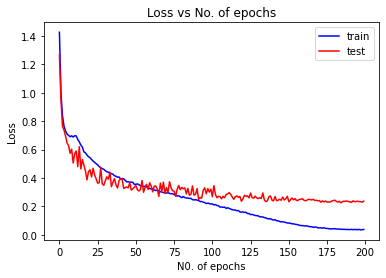

In [11]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss_list)), train_loss_list, 'b')
plt.plot(range(len(test_loss_list)), test_loss_list, 'r')

plt.xlabel("N0. of epochs")
plt.ylabel("Loss")
plt.title("Loss vs No. of epochs")
plt.legend(['train', 'test'])
plt.show()

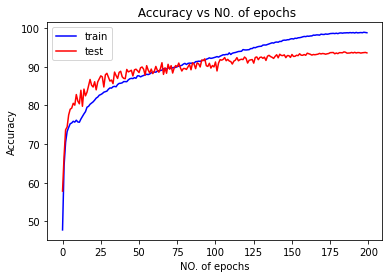

In [12]:
plt.plot(range(len(train_acc_list)), train_acc_list, 'b')
plt.plot(range(len(test_acc_list)), test_acc_list, 'r')
plt.xlabel("NO. of epochs")
plt.ylabel("Accuracy")
plt.title(" Accuracy vs N0. of epochs")
plt.legend(['train', 'test']) 
plt.show()